# PyTorch Neural Network Classifications

Classification is a problem of predicting weather something is one thing or another. (Photos of dogs or cats, etc.)

- [Course Video](https://youtu.be/V_xro1bcAuA)
- [Resource Notebook](https://www.learnpytorch.io/)
- [GitHub Discussions](https://github.com/mrdbourke/pytorch-deep-learning)

In [51]:
# Import Modules
import torch
from torch import nn
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Check PyTorch Version
torch.__version__

'2.2.1+cu121'

In [52]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device {device}")

Using Device cpu


# Make and prepare classification data

In [53]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(
    n_samples,
    noise = 0.03,
    random_state = 42
)

In [54]:
print(f"First 5 samples of X: \n {X[:5]}")
print(f"First 5 samples of y: \n {y[:5]}")

First 5 samples of X: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: 
 [1 1 1 1 0]


In [55]:
# Make and view dataframe of circle data
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


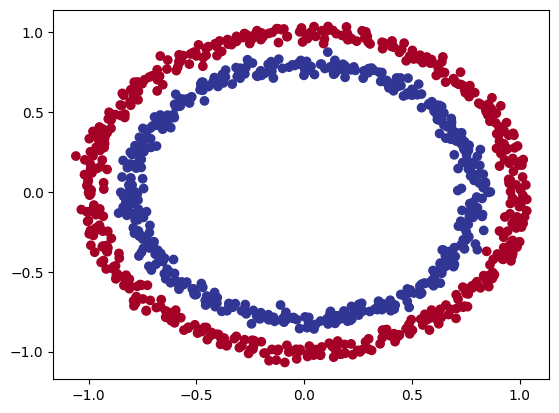

In [56]:
# Visualizing above data
plt.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = y,
    cmap = plt.cm.RdYlBu
);

- Note: The data we're working with is often refered to as a toy dataset, a dataset which is small enough to experiment on but small enough to practice the fundamentals.
- What we want to do with this dataset - given the x and y coordinates (X1, X2), we have to predict the color of the circle (y)

## Check input and output shapes

In [57]:
# Currently numpy arrays
X.shape, y.shape

((1000, 2), (1000,))

In [58]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample}")
print(f"Shape of one sample of X: {X_sample.shape}")
print(f"Values for one sample of y: {y_sample}")
print(f"Shape of one sample of y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074]
Shape of one sample of X: (2,)
Values for one sample of y: 1
Shape of one sample of y: ()


## Turn data into tensors

In [59]:
X, y = torch.from_numpy(X).type(torch.float32), torch.from_numpy(y).type(torch.float32)

X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

## Split data into train and test sets

In [60]:
# Split data into train and test sets randomly
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size = 0.2, # 0.2 = 20% of data will be test data, and 80% will be train
  random_state = 42
)

In [61]:
# Check the split
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Build a Model

Let's build a model to classify the blue and red dots. To do so, we want:
1. Construct a model (by subclassing `nn.Module`)
2. Define a loss function and optimizer.
3. Write train and test loop.

## Construct Model

Model Creation To-do:
1. Subclass `nn.Module`.
2. Create two `nn.Linear` layers that are capable of handling the shaped of our data.
3. Define a `forward()` method that outlines the forward pass of the model.
4. Instantiate an instance of out model class and send it to the target device.

In [62]:
# Construct a model that subclasses nn.Model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Create two nn.Linear layers capale of handling the shapes of our data
    self.layer_1 = nn.Linear( # takes in 2 features and upscales to 8 features
        in_features = 2,
        out_features = 8
    )

    self.layer_2 = nn.Linear( # takes in 8 features from previous layer and computes a single feature with the same shape of y
        in_features = 8,
        out_features = 1
    )

  # Define forward() method
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# Make instance of model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [63]:
# Replicating above model using nn.Sequential
model_0 = nn.Sequential(
  nn.Linear(in_features=2, out_features=8),
  nn.Linear(in_features=8, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [64]:
# Make some untrained predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\n First 10 Predictions: \n {torch.round(untrained_preds[:10])}")
print(f"\n First 10 labels: \n {y_test[:10]}")

Length of predictions: 200, shape: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])

 First 10 Predictions: 
 tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]])

 First 10 labels: 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Define loss function and optimizer

Which loss function should we use? It actually depends on the problem.
- With regression, we used MAE, which may or may not work with classification.
- With classification, we need binary cross entropy, or categorial cross entropy.

And for optimizers,SGD and Adam are the most common, however PyTorch has many built-in options.

For the loss function, we're going to use `torch.nn.BCEWithLogitsLoss()`. Read more about BCE and Logits.

In [65]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # This has the sigmoid activation function combined with the BCE Loss

# Setup optimizer
optimizer = torch.optim.SGD(
    params = model_0.parameters(),
    lr = 0.1
)

## Define Accuracy Function

Out of 100 examples, what percentage does our model get right.


In [66]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

# Train Model

Steps for training loop:
1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss backward (backpropogation)
5. Optimizer Step (gradient descent)

## Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probibilities by passing them to some kind of activation function (eg. sigmoid for binary crossentropy and softmax for multiclass classification).

Then we can convert our model's predictions to prediction labels by either rounding (binary crossentropy) them or taking the argmax (softmax).

In [67]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.4038],
        [-0.3557],
        [-0.4277],
        [-0.3974],
        [-0.2659]])

In [68]:
# Use sigmoid activation function on out model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4004],
        [0.4120],
        [0.3947],
        [0.4019],
        [0.4339]])

For our prediction probability values, we need to perform a range-style rounding on them:
- `y_pred_probs` >= `0.5` --> `y = 1` (class 1)
- `y_pred_probs` < 0.5 --> `y = 0` (class 0)

In [69]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [70]:
# Find the prediction labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

## Building a train test loop

In [71]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put Data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training and testing loop
for epoch in range(epochs):
  # Training
  model_0.train()

  ## Forward Pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred_probs -> pred_labels

  #3 Calculate loss / accuracy
  loss = loss_fn( # nn.BCEWithLogitsLoss expects raw logits as imput
      y_logits,
      y_train
  )

  acc = accuracy_fn(
      y_true = y_train,
      y_pred = y_pred
  )

  ## Optimizer zero grad
  optimizer.zero_grad()

  ## Loss backward
  loss.backward()

  ## Optimizer step
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    ## forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    ## calculate test loss / accuracy
    test_loss = loss_fn(
        test_logits,
        y_test
    )
    test_acc = accuracy_fn(
        y_true = y_test,
        y_pred = test_pred
    )

  # print out whats happening
  if epoch %10 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0, Loss: 0.70808, Acc: 50.00%, Test Loss: 0.70728, Test Acc: 50.00%
Epoch: 10, Loss: 0.69666, Acc: 50.00%, Test Loss: 0.69750, Test Acc: 50.00%
Epoch: 20, Loss: 0.69394, Acc: 45.88%, Test Loss: 0.69523, Test Acc: 42.00%
Epoch: 30, Loss: 0.69328, Acc: 46.88%, Test Loss: 0.69470, Test Acc: 49.00%
Epoch: 40, Loss: 0.69311, Acc: 49.25%, Test Loss: 0.69457, Test Acc: 49.00%
Epoch: 50, Loss: 0.69306, Acc: 50.00%, Test Loss: 0.69453, Test Acc: 48.50%
Epoch: 60, Loss: 0.69304, Acc: 50.50%, Test Loss: 0.69451, Test Acc: 47.50%
Epoch: 70, Loss: 0.69303, Acc: 50.75%, Test Loss: 0.69450, Test Acc: 47.50%
Epoch: 80, Loss: 0.69302, Acc: 50.38%, Test Loss: 0.69450, Test Acc: 48.00%
Epoch: 90, Loss: 0.69301, Acc: 51.12%, Test Loss: 0.69449, Test Acc: 48.00%
Epoch: 100, Loss: 0.69301, Acc: 51.00%, Test Loss: 0.69449, Test Acc: 47.00%
Epoch: 110, Loss: 0.69300, Acc: 51.38%, Test Loss: 0.69449, Test Acc: 47.00%
Epoch: 120, Loss: 0.69300, Acc: 51.12%, Test Loss: 0.69450, Test Acc: 47.00%
Epoch: 130

# Make predictions and evaluate the model

From the above print statements, it looks like our model is not learning anything.

So to inspect our model, let's make some predcitions amd make them visual.

To do so, we're going to import a function called `plot_decision_boundary()`.

In [72]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if its not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


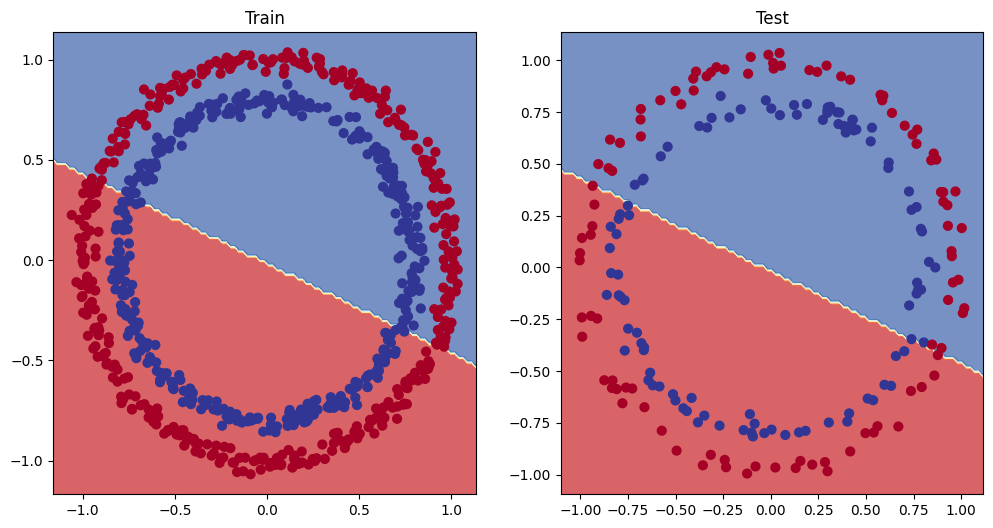

In [73]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Improving a model

(from a model perspective)
- Add more layers - give the model more chances to learn about patterns in the data.
- Add more hidden units - go from 8 hidden units to 16 hidden units. The same principle as above.
- Fit for longer
- Changing the activation functions
- Change the learning rate
- Change the loss function

All the options are from a model perspective because then deal directly with the model, rather than the data.

And because these options are all values we can change, they are referred to as hyperparameters.

So, lets try and improve our model by:
- Increase the number of hidden units / neurons
- Increase the number of layers  
- Increase the number of epochs

## Trying to improve model by increasing number of hidden units, layers, and epochs

In [74]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=16)
    self.layer_2 = nn.Linear(in_features=16, out_features=16)
    self.layer_3 = nn.Linear(in_features=16, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
)

- Now that we have more hidden units and more layers to our model, lets see if the results improve.

In [75]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an Optimizer
optimizer = torch.optim.SGD(
    params = model_1.parameters(),
    lr = 0.1
)

In [76]:
# Write Training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Training
  model_1.train()

  # forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss / acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(
    y_true = y_train,
    y_pred = y_pred
  )

  # optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # optimizer step
  optimizer.step()

  # Test
  model_1.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # Calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(
      y_true = y_test,
      y_pred = test_pred
    )

  # print whats happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0, Loss: 0.69618, Acc: 50.00%, Test Loss: 0.69344, Test Acc: 50.00%
Epoch: 100, Loss: 0.69300, Acc: 51.25%, Test Loss: 0.69410, Test Acc: 46.00%
Epoch: 200, Loss: 0.69298, Acc: 51.25%, Test Loss: 0.69458, Test Acc: 45.00%
Epoch: 300, Loss: 0.69298, Acc: 51.12%, Test Loss: 0.69466, Test Acc: 46.00%
Epoch: 400, Loss: 0.69298, Acc: 51.00%, Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 500, Loss: 0.69298, Acc: 51.00%, Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 600, Loss: 0.69298, Acc: 51.00%, Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 700, Loss: 0.69298, Acc: 51.00%, Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 800, Loss: 0.69298, Acc: 51.00%, Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 900, Loss: 0.69298, Acc: 51.00%, Test Loss: 0.69468, Test Acc: 46.00%


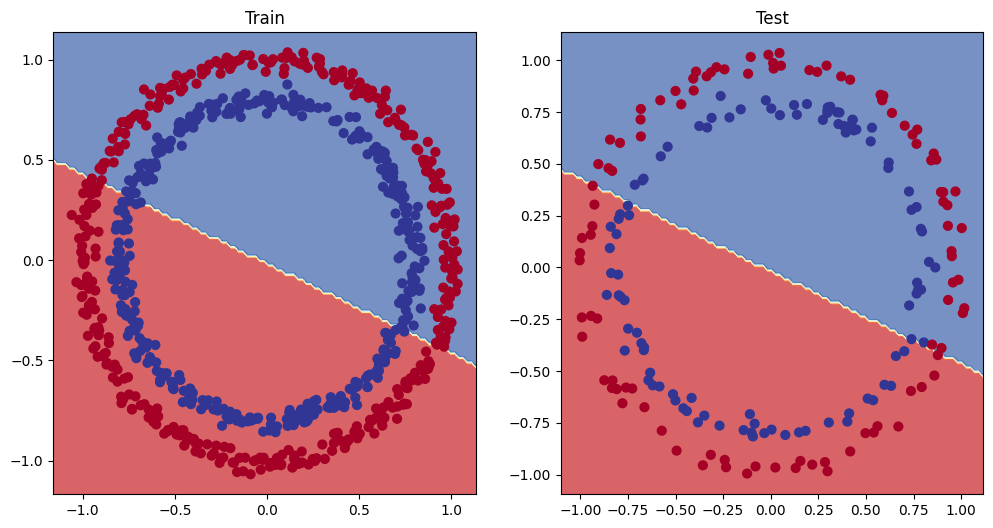

In [77]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## Preparing data to see if our model can fit a straight line.

One way to troubleshoow to a larger problem is to test out a smaller problem.

In [78]:
# Create some data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Create train test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

In [79]:
# Defien plot_predictions() function
def plot_predictions(
    train_data = X_train_regression,
    train_labels = y_train_regression,
    test_data = X_test_regression,
    test_labels = y_test_regression,
    predictions = None,
    title=None
):
  plt.figure(figsize=(10, 7))

  # plot training data
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

  # plot testing data
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

  # are there predictions?
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", label="Predictions")

  if title is not None:
    plt.title(label=title)

  # Show the legend
  plt.legend(prop={"size": 12});

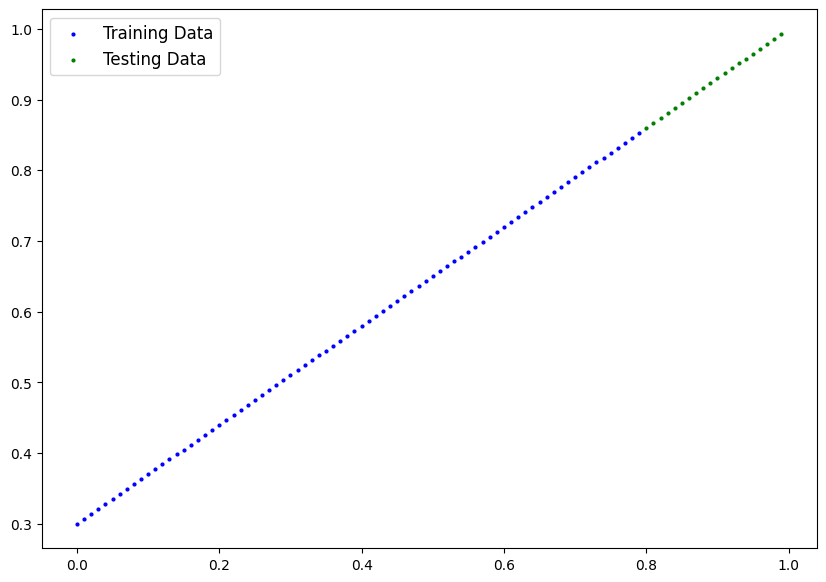

In [80]:
plot_predictions()

In [81]:
# Creating a new model the same architecture as model_1 using nn.Sequential()
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [82]:
# loss and optimizer
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(
    params = model_2.parameters(),
    lr=0.003
)

In [83]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 1000

# put data on target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Write Train and test loop
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.5f}, Test Loss: {test_loss:.5f}")


Epoch: 0, Loss: 0.75986, Test Loss: 0.94104
Epoch: 100, Loss: 0.01484, Test Loss: 0.03333
Epoch: 200, Loss: 0.00211, Test Loss: 0.01418
Epoch: 300, Loss: 0.00238, Test Loss: 0.01427
Epoch: 400, Loss: 0.00297, Test Loss: 0.01393
Epoch: 500, Loss: 0.00324, Test Loss: 0.01403
Epoch: 600, Loss: 0.00350, Test Loss: 0.01414
Epoch: 700, Loss: 0.00376, Test Loss: 0.01424
Epoch: 800, Loss: 0.00401, Test Loss: 0.01435
Epoch: 900, Loss: 0.00426, Test Loss: 0.01447


<ipython-input-84-ca1ac0d9db51>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_predictions(predictions=torch.tensor(y_preds_regression).cpu().numpy())


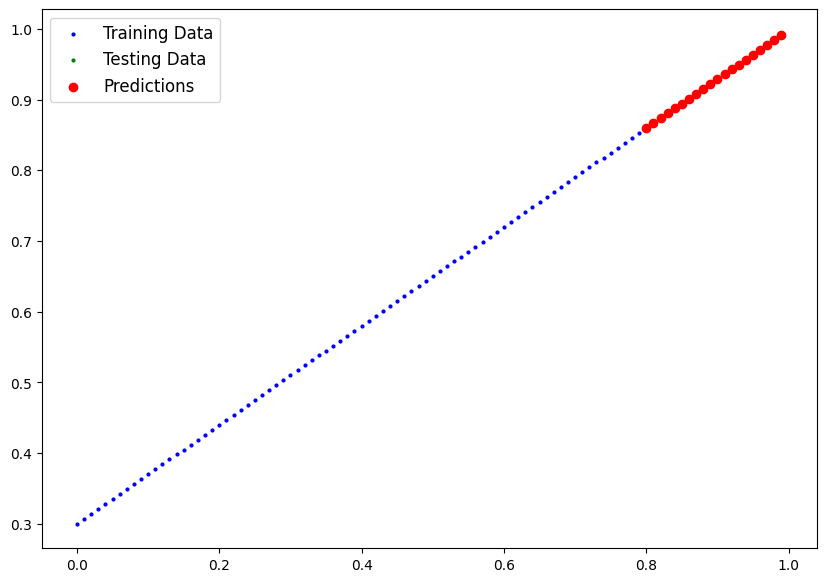

In [84]:
model_2.eval()
with torch.inference_mode():
  y_preds_regression = model_2(X_test_regression)
plot_predictions(predictions=torch.tensor(y_preds_regression).cpu().numpy())

- As visible, our similar model is able to learn and produce accurate results on a straight line dataset.

# The Missing Piece - Non-linearity

"What patterns could you draw if you were given an infinite amount of straight or non-straight lines?"

Or in machine learning terms, an infinite number of linear and non-linear functions.

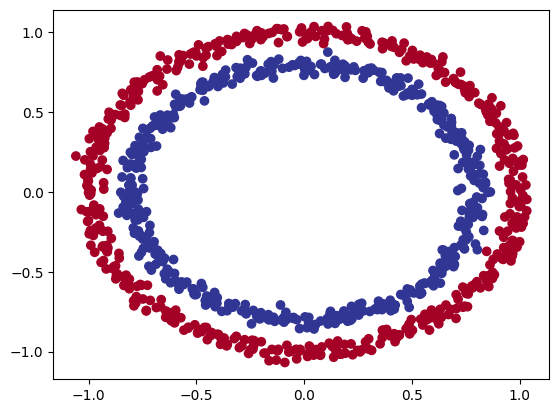

In [85]:
# Plotting non-linear data again
plt.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = y,
    cmap = plt.cm.RdYlBu
);

## Building a model with non-linearity.

- Linear = Straight Lines
- Non-Linear = Non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-lineae) functions which are able to find patterns in data.

In [86]:
# Coding a classification model with non-linear activation functions
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=8)
    self.layer_3 = nn.Linear(in_features=8, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function.

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [87]:
# Instantiate model
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

## Training Non-linear model



In [88]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
  model_3.parameters(),
  lr = 0.1
)

In [89]:
# Write train test loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3000

# Put data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# loop through data
for epoch in range(epochs):
  # Train
  model_3.train

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # test
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print whats happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Loss = {loss:.4f}, Acc = {acc:.2f}#, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0, Loss = 0.6927, Acc = 50.00#, Test Loss: 0.6900, Test Acc: 50.00%
Epoch: 100, Loss = 0.6904, Acc = 50.75#, Test Loss: 0.6877, Test Acc: 56.00%
Epoch: 200, Loss = 0.6889, Acc = 51.62#, Test Loss: 0.6857, Test Acc: 56.00%
Epoch: 300, Loss = 0.6869, Acc = 52.00#, Test Loss: 0.6832, Test Acc: 55.50%
Epoch: 400, Loss = 0.6840, Acc = 52.38#, Test Loss: 0.6800, Test Acc: 56.00%
Epoch: 500, Loss = 0.6797, Acc = 54.12#, Test Loss: 0.6754, Test Acc: 56.50%
Epoch: 600, Loss = 0.6726, Acc = 60.62#, Test Loss: 0.6684, Test Acc: 60.50%
Epoch: 700, Loss = 0.6609, Acc = 72.12#, Test Loss: 0.6579, Test Acc: 74.00%
Epoch: 800, Loss = 0.6395, Acc = 77.50#, Test Loss: 0.6409, Test Acc: 80.50%
Epoch: 900, Loss = 0.5974, Acc = 87.88#, Test Loss: 0.6061, Test Acc: 88.00%
Epoch: 1000, Loss = 0.5199, Acc = 94.00#, Test Loss: 0.5383, Test Acc: 90.50%
Epoch: 1100, Loss = 0.4014, Acc = 96.50#, Test Loss: 0.4315, Test Acc: 94.50%
Epoch: 1200, Loss = 0.2658, Acc = 98.88#, Test Loss: 0.3032, Test Acc: 97.00

## Evaluating the non-linear model

In [90]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

- As visible, the model is able to predict and is accurate

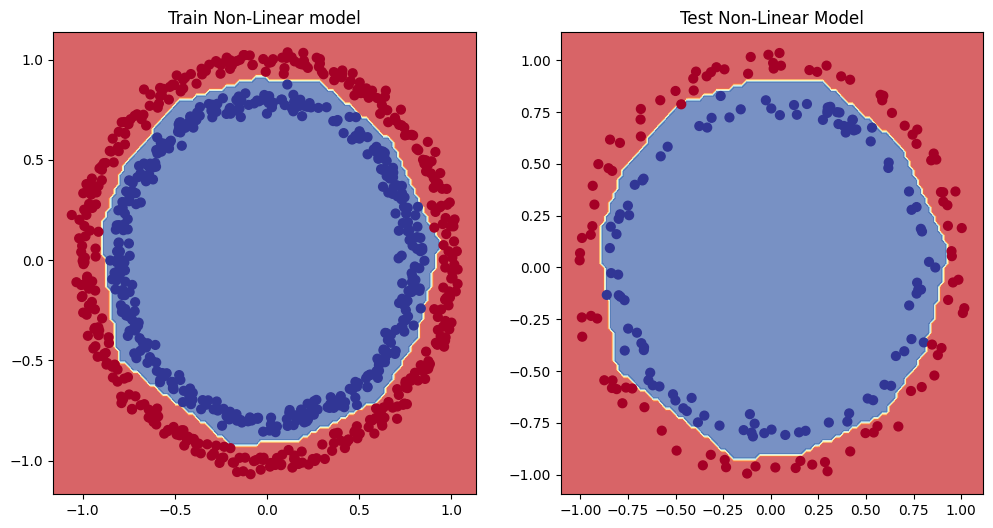

In [91]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train Non-Linear model")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test Non-Linear Model")
plot_decision_boundary(model_3, X_test, y_test)

- And as visible. the decision boundaries based on our model's predicitons is really accurate.

# Replicating Non-Linear Activations

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data, and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions.

In [92]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

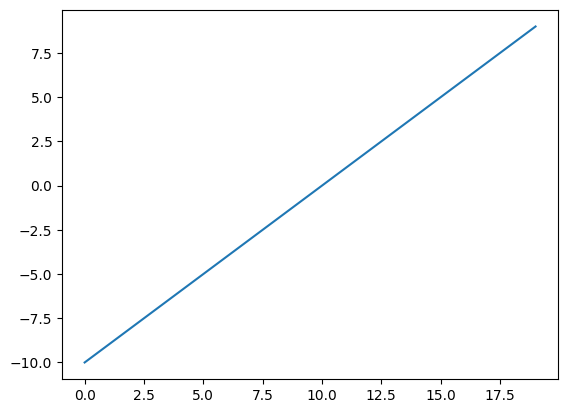

In [93]:
plt.plot(A)

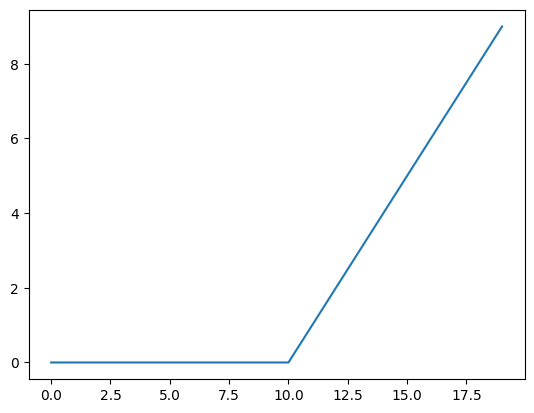

In [94]:
plt.plot(torch.relu(A))

In [95]:
# recreating relu
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

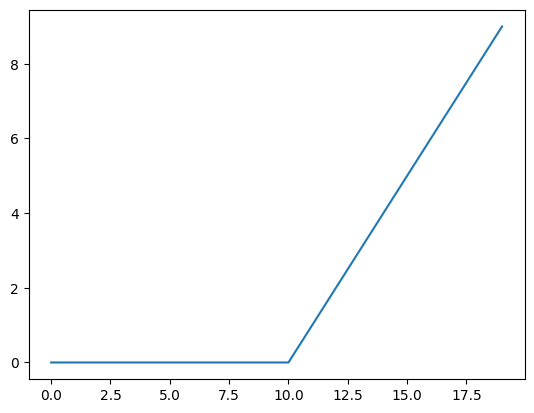

In [96]:
plt.plot(relu(A))

- relu basically converts all negative values to zero.

In [97]:
# recreating sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

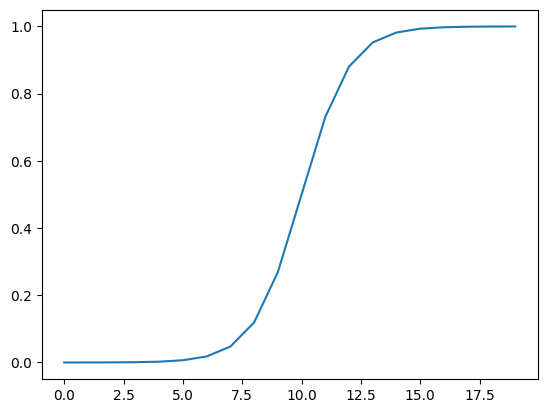

In [98]:
plt.plot(sigmoid(A))

# Putting it all together with a multi-class problem

- Binary classification -> One thing or the other (cat vs. dog).
- Multi-class -> More than one thing or another (cat vs. dog vs. chicken).


## Getting Data

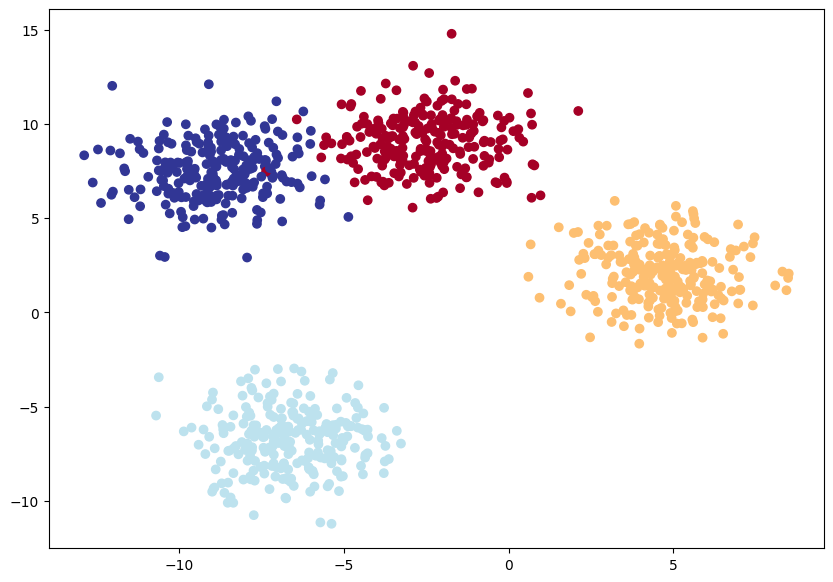

In [140]:
# import dependencies for data and splitting data
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(
  n_samples=1000,
  n_features = NUM_FEATURES,
  centers=NUM_CLASSES,
  cluster_std=1.5,
  random_state=RANDOM_SEED
)

# turn data into tensors
X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float32), torch.from_numpy(y_blob).type(torch.LongTensor)

# Split into train-test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(
  X_blob[:, 0],
  X_blob[:, 1],
  c=y_blob,
  cmap=plt.cm.RdYlBu
)

## Build a multi-class classification model



In [197]:
# building model
class BlobModelV0(nn.Module):
  def __init__(self, input_features=2, output_features=4, hidden_units=8):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [198]:
# create an instance of model
model_4 = BlobModelV0().to(device)
model_4

BlobModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Train multi-class classification model



- We will be using a cross entropy loss function.
- And SGD / Adam optimizer.

In [199]:
# Create loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model_4.parameters(),
    lr = 0.03
)

### Getting prediction probabilities for a multi-class model

In order to train, test our model, we need to convert out model's outputs (logits) to prediction probabilities and then to prediction labels. italicized text

In [200]:
# lets get raw outputs of our model
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(torch.float32))
y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]])

In [201]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [202]:
# convert model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])


In [203]:
# after softmax they all sum up to 1
torch.sum(y_pred_probs[0])

tensor(1.)

In [204]:
torch.argmax(y_pred_probs[0])

tensor(3)

In [205]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3])

In [206]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

- Now, we've got our model's prediction outputs in the same format as the test labels.

### Create Training and testing loop



In [207]:
# Fit the multi class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set epochs
epochs = 400

# set tensors to the device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Write train test loop
for epoch in range(epochs):
  # Train
  model_4.train()

  y_logits = model_4(X_blob_train.to(torch.float32))
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # test
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test.to(torch.float32))
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

  # print out
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0, Loss: 1.0432, Acc: 65.50%, Test Loss: 0.8474, Test Acc: 73.50%
Epoch: 100, Loss: 0.0602, Acc: 99.12%, Test Loss: 0.0533, Test Acc: 99.50%
Epoch: 200, Loss: 0.0394, Acc: 99.00%, Test Loss: 0.0313, Test Acc: 99.50%
Epoch: 300, Loss: 0.0331, Acc: 99.12%, Test Loss: 0.0245, Test Acc: 99.50%


## Evaluating the trained model



In [208]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_blob_preds = torch.softmax(model_4(X_blob_test), dim=1).argmax(dim=1)

y_blob_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

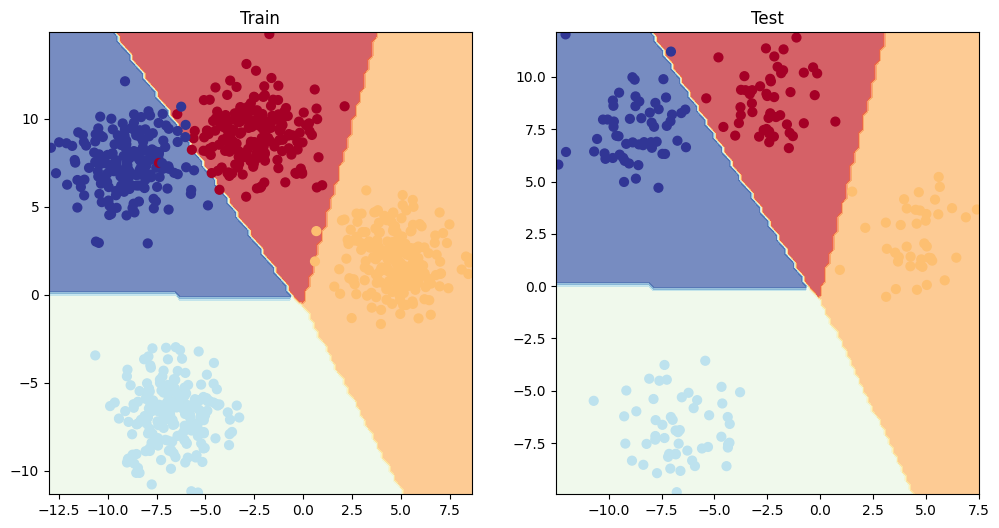

In [210]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

- As visible, the model we trained for 400 epochs is pretty accurate.

## A few classification metrics...

- Accuracy
- Precision
- Recall
- F1-score
- Confusion matrix
- Classification report

(extra curriculum, read more on the web)